In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn

In [2]:
raw_data = pd.read_csv("raw_data.csv", parse_dates=[0], index_col=0)

In [3]:
raw_data.head()

,pm25,t2m,d2m,u10,v10
2016-01-01 08:00:00,106,266.158697,262.942797,0.610000,-0.854401
2016-01-01 14:00:00,172,277.572013,265.854378,0.539951,0.014327
2016-01-01 20:00:00,260,271.109503,266.588183,1.231592,-0.007235
2016-01-02 02:00:00,306,266.704619,264.173029,0.891609,-1.404387
2016-01-02 08:00:00,195,266.042011,262.649275,0.834297,-1.433449


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
data = series_to_supervised(raw_data,4,1)
data.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2016-01-02 08:00:00,106.0,266.158697,262.942797,0.610000,-0.854401,172.0,277.572013,265.854378,0.539951,0.014327,...,306.0,266.704619,264.173029,0.891609,-1.404387,195,266.042011,262.649275,0.834297,-1.433449
2016-01-02 14:00:00,172.0,277.572013,265.854378,0.539951,0.014327,260.0,271.109503,266.588183,1.231592,-0.007235,...,195.0,266.042011,262.649275,0.834297,-1.433449,210,279.451486,266.322240,-0.287542,-0.858151
2016-01-02 20:00:00,260.0,271.109503,266.588183,1.231592,-0.007235,306.0,266.704619,264.173029,0.891609,-1.404387,...,210.0,279.451486,266.322240,-0.287542,-0.858151,416,273.128582,265.770655,-0.589317,-1.276265
2016-01-03 02:00:00,306.0,266.704619,264.173029,0.891609,-1.404387,195.0,266.042011,262.649275,0.834297,-1.433449,...,416.0,273.128582,265.770655,-0.589317,-1.276265,482,268.245495,264.837886,-0.198389,-1.861250
2016-01-03 08:00:00,195.0,266.042011,262.649275,0.834297,-1.433449,210.0,279.451486,266.322240,-0.287542,-0.858151,...,482.0,268.245495,264.837886,-0.198389,-1.861250,178,267.091140,264.431092,-0.402167,-1.321264


In [6]:
values = data.values

In [7]:
# n_train_samples = 1000
# n_test_samples = 500
# train = values[:n_train_samples, :]
# test = values[-n_test_samples:, :]
rmse_list = []
for i in range(10):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :20]
    train_y = train[:,20]
    test_X = test[:, :20]
    test_y = test[:,20]
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y)
    y_predict = reg.predict(test_X)
    m = mean_squared_error(y_predict, test_y)
    RMSE = math.sqrt(m)
    rmse_list.append(RMSE)
print(np.mean(rmse_list))

49.21156810489373


In [8]:
train.shape

(2131, 25)

In [9]:
test.shape

(533, 25)

In [30]:
train_X.shape

(2131, 20)

In [31]:
train_y.shape

(2131,)

In [32]:
test_X.shape

(533, 20)

In [33]:
test_y.shape

(533,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
y_predict = reg.predict(test_X)
y_predict

array([ 7.08158086e+01,  5.28250808e+01,  1.75186697e+02,  7.40943731e+01,
        2.76746447e+01,  6.77713345e+01,  7.04971912e+01,  7.79950267e+01,
        4.75427946e+01,  4.75914936e+01,  1.77196229e+02,  5.17559433e+01,
        6.13805689e+01,  9.28046876e+01,  2.16806877e+02,  7.48357215e+01,
        1.33920906e+02,  2.43947914e+01,  1.04370152e+02,  1.92564471e+02,
        1.83135916e+02,  7.18863262e+01,  3.76787271e+01,  9.37529549e+01,
        4.36532365e+01,  8.23576503e+01,  1.63060479e+01,  3.25182025e+01,
        7.31484322e+01,  4.20473537e+01,  2.98005542e+01,  2.55343681e+01,
        1.10025190e+02,  7.54906350e+01,  2.96945611e+01,  4.84584436e+01,
        5.19840019e+01,  1.25328859e+01,  5.32961603e+01,  4.38533790e+01,
        2.43301455e+02,  8.15954660e+01,  1.20295125e+01,  7.71584271e+00,
        4.93281985e+01,  9.09325202e+01,  6.13993024e+01,  7.27400217e+00,
        3.81824336e+01,  4.70398543e+01,  6.27193505e+01,  4.32072188e+01,
        2.89159279e+01,  

In [17]:
y_predict.shape

(500,)

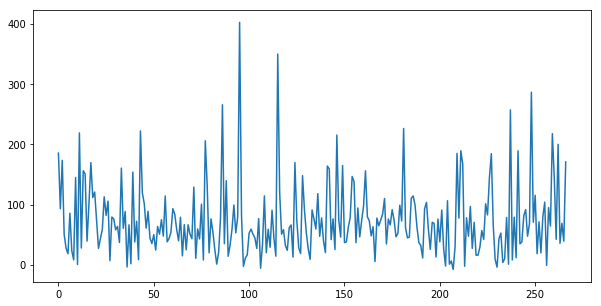

In [50]:
plt.plot(np.arange(len(y_predict)), y_predict)

In [19]:
np.arange(len(y_predict))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

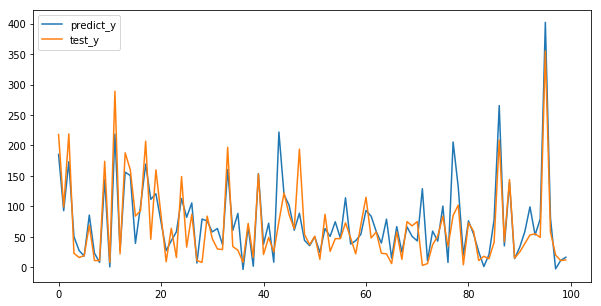

In [52]:
plt.plot(np.arange(len(y_predict[:100])), y_predict[:100], label = "predict_y")
plt.plot(np.arange(len(y_predict[:100])), test_y[:100], label = "test_y")
plt.legend()
plt.show()

In [21]:
m = mean_squared_error(y_predict, test_y)

In [29]:
RMSE = math.sqrt(m)
RMSE

31.003823276418057

# SVR 

In [8]:
from sklearn import svm

In [12]:
# n_train_samples = 1000
# n_test_samples = 500
# train = values[:n_train_samples, :]
# test = values[-n_test_samples:, :]

# Grid search 
rmse_list = []
C_list = [1e3, 1e4, 1e5]
gamma_list = np.logspace( -6, -2, 5)
rmse_matrix = np.zeros((len(C_list), len(gamma_list)))
for i in range(1):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :20]
    train_y = train[:,20]
    test_X = test[:, :20]
    test_y = test[:,20]
    for c_index, c in enumerate(C_list):
        for g_index, g in enumerate(gamma_list):
            print(c_index)
            print(g_index)
            clf = svm.SVR(kernel='rbf', C=c, gamma=g)
            clf.fit(train_X, train_y)
            print("completed training")
            y_predict = clf.predict(test_X)
            print("completed predicting")
            RMSE = math.sqrt(mean_squared_error(y_predict, test_y)) 
            
            rmse_matrix[c_index, g_index] = RMSE
print(rmse_matrix)

0
0
completed training
completed predicting
0
1
completed training
completed predicting
0
2
completed training
completed predicting
0
3
completed training
completed predicting
0
4
completed training
completed predicting
1
0
completed training
completed predicting
1
1
completed training
completed predicting
1
2
completed training
completed predicting
1
3
completed training
completed predicting
1
4
completed training
completed predicting
2
0
completed training
completed predicting
2
1
completed training
completed predicting
2
2
completed training
completed predicting
2
3
completed training
completed predicting
2
4
completed training
completed predicting
[[47.32709487 50.01133801 59.19349602 71.25190417 81.40719325]
 [48.27961804 59.16378215 67.15037661 72.73889683 81.40719325]
 [50.9920709  83.92502223 78.41820506 76.61230531 81.40719325]]


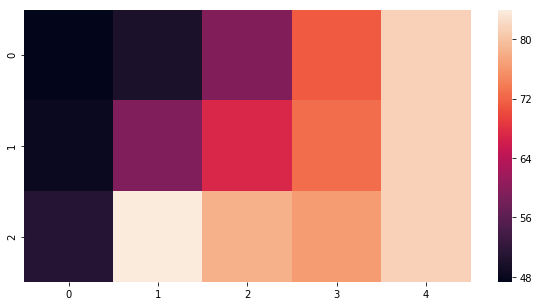

In [14]:
seaborn.heatmap(rmse_matrix)

In [11]:
train, test = train_test_split(values, test_size=0.2)
train_X = train[:, :20]
train_y = train[:,20]
test_X = test[:, :20]
test_y = test[:,20]
clf = svm.SVR(kernel='rbf', C=1e5, gamma=1e-6)
clf.fit(train_X, train_y)
print("completed training")
y_predict = clf.predict(test_X)
print("completed predicting")
RMSE = math.sqrt(mean_squared_error(y_predict, test_y)) 
print(RMSE)

completed training
completed predicting
45.82473014286533


In [12]:
gamma_list

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [89]:
m1 = mean_squared_error(y1_predict, test_y)
RMSE1 = math.sqrt(m1)
RMSE1

30.714337186289463

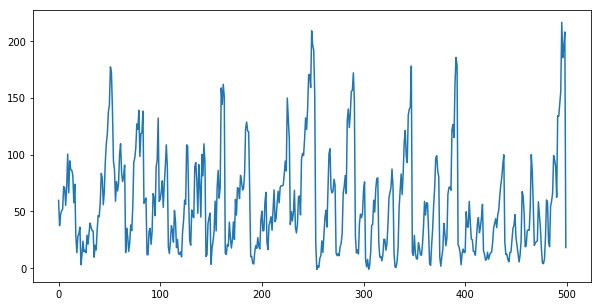

In [90]:
plt.plot(np.arange(len(y1_predict)), y1_predict)

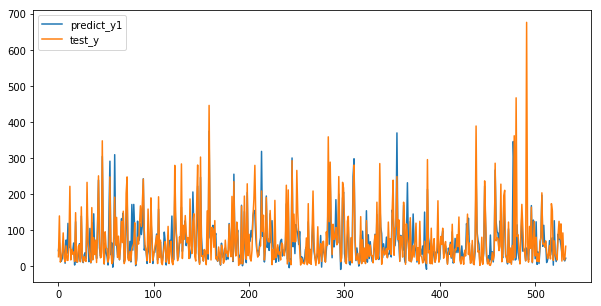

In [63]:
plt.plot(np.arange(len(y_predict)), y_predict, label = "predict_y1")
plt.plot(np.arange(len(y_predict)), test_y, label = "test_y")
plt.legend()
plt.show()